In [20]:
import numpy as np
import pandas as pd
import os

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation
from collections import Counter

import tensorflow as tf
from tensorflow.python.keras import Model



In [ ]:
def rearrange_data(train_test, label):
    content = []
    for filepath in os.listdir('data/' + train_test + '/' + label):
        with open(('data/' + train_test + '/' + label + '/' + filepath), 'r') as file:
            review = file.read()
            content.append(review)
    with open('data/' + train_test + '/' + label + '.txt', 'w') as target_file:
        target_file.write('\n'.join(content))
        print(target_file.name)


rearrange_data('train', 'pos')
rearrange_data('train', 'neg')

rearrange_data('test', 'pos')
rearrange_data('test', 'neg')



data/train/pos.txt


data/train/neg.txt


data/test/pos.txt


data/test/neg.txt


In [15]:
class DataGenerator():
    def __init__(self):
        self.train = pd.DataFrame(columns=['review', 'sentiment'])
        self.train = self.train.append(self.create_df_from_filepath('train', 'pos.txt', 1), ignore_index=True)
        self.train = self.train.append(self.create_df_from_filepath('train', 'neg.txt', -1), ignore_index=True)
        
        self.test = pd.DataFrame(columns=['review', 'sentiment'])
        self.test = self.test.append(self.create_df_from_filepath('test', 'pos.txt', 1), ignore_index=True)
        self.test = self.test.append(self.create_df_from_filepath('test', 'neg.txt', -1), ignore_index=True)
        
        self.preprocessing() 
        
    @staticmethod
    def create_df_from_filepath(train_test, filename, label):
        with open('data/' + train_test + '/' + filename, 'r') as file:
            review = file.read().split('\n')
            review = pd.DataFrame({'review': review})
            review['sentiment'] = pd.Series(np.array([label]*len(review)), index=review.index)
            return review
        
    def preprocessing(self):
        self.train['review'] = self.train['review'].apply(lambda x: x.lower())
        self.test['review'] = self.test['review'].apply(lambda x: ''.join([c for c in x if c not in punctuation]))

        all_text = ' '.join(self.train['review'])
        words = all_text.split()
        count_words = Counter(words)
        total_words = len(words)
        sorted_words = count_words.most_common(total_words)

        vocab_to_int = {w: i+1 for i, (w, c) in enumerate(sorted_words)}
        
        self.reviews_int = []
        for review in self.train['review']:
            r = [vocab_to_int[w] for w in review.split()]
            self.reviews_int.append(r)
    
    
data_gen = DataGenerator()
data_gen.train.tail()


,review,sentiment
24995,"my comments may be a bit of a spoiler, for wha...",-1
24996,"the ""saucy"" misadventures of four au pairs who...",-1
24997,"oh, those italians! assuming that movies about...",-1
24998,eight academy nominations? it's beyond belief....,-1
24999,"not that i dislike childrens movies, but this ...",-1


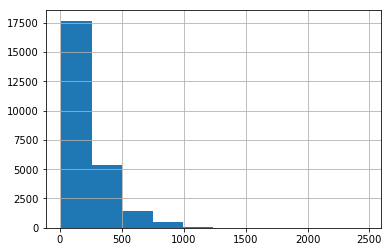

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
dtype: float64

In [16]:
reviews_len = [len(x) for x in data_gen.reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [17]:
reviews_int = [data_gen.reviews_int[i] for i, l in enumerate(reviews_len) if l > 0]
encoded_labels = [data_gen.train['sentiment'][i] for i, l in enumerate(reviews_len) if l > 0]


In [18]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype=int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i, :] = np.array(new)
    
    return features


In [19]:
features = pad_features(data_gen.reviews_int, 500)
print(features[:10, :])


[[    0     0     0 ...     2   564  9044]
 [    0     0     0 ... 15979    33  2341]
 [    0     0     0 ...  9840     1 69434]
 ...
 [    0     0     0 ...     5    56   665]
 [    0     0     0 ...   106   266  2146]
 [    0     0     0 ... 12645    12   710]]


In [ ]:
class LSTMNetwork(Model):
    